## OpenCV

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

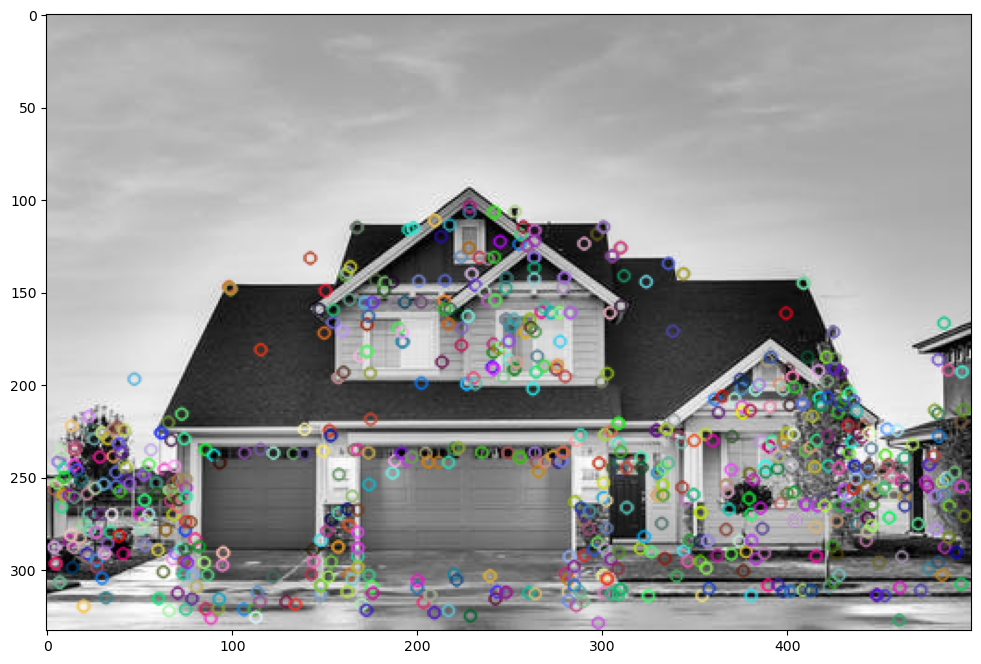

In [11]:
img = cv2.imread('./data/house.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp = sift.detect(gray, None)
img = cv2.drawKeypoints(gray, kp, img)

plt.figure(figsize=(15,8))
plt.imshow(img)

- DrawMatchesFlags_DRAW_RICH_KEYPOINTS
    - Keypoint의 정보를 rich하게 표현.
    - Scale과 orientation까지 시각화.

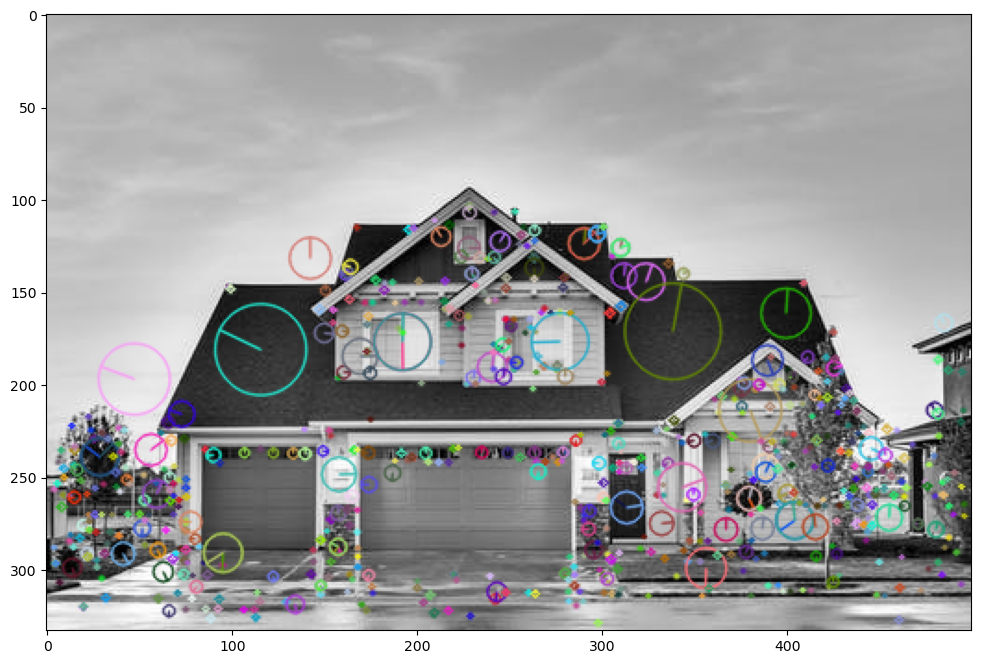

In [12]:
img = cv2.drawKeypoints(gray, kp, img, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(15,8))
plt.imshow(img)

In [13]:
# Confidence score 순서상 첫 keypoint의 정보
# Dominant angle, octave, coordinates, response, size
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(gray, None)

print("angle: {:.2f} \n octave: {:.2f} \n coordinates: ({:.2f} {:.2f}) \n response: {:.2f} \n size: {:.2f} \n".format(kp[0].angle, kp[0].octave, kp[0].pt[0], kp[0].pt[1], kp[0].response, kp[0].size))

kp = np.array([i.pt for i in kp])
print(kp.shape) # 740개의 keypoints
print(des.shape) # Descriptor dim = 128

angle: 357.10 
 octave: 2294271.00 
 coordinates: (3.84 287.84) 
 response: 0.07 
 size: 1.85 

(740, 2)
(740, 128)


## Kornia

- PyTorch Ported Library

In [14]:
import torch
import kornia
import kornia.feature as KF
from torchvision import transforms
from PIL import Image

In [15]:
filename = './data/house.jpeg'
tensor = transforms.ToTensor()(Image.open(filename).convert('L')).unsqueeze(0) # batch size를 1로 주기 위해

print(tensor.shape)

torch.Size([1, 1, 333, 500])


### DoG detector + (root) SIFT descriptor

- root : L2-normalized SIFT
    - Vector size로 normalize

In [16]:
sift = KF.SIFTFeature(num_features=2000)
print(sift)

SIFTFeature(
  (detector): MultiResolutionDetector(
    (model): BlobDoGSingle, sigma1=1.0, sigma2=1.6)
    (nms): NonMaximaSuppression2d()
    (ori): LAFOrienter(patch_size=19, angle_detector=PatchDominantGradientOrientation(patch_size=19, num_ang_bins=36, eps=1e-08))
    (aff): PassLAF()
  )
  (descriptor): LAFDescriptor(descriptor=SIFTDescriptor(num_ang_bins=8, num_spatial_bins=4, patch_size=41, rootsift=True, clipval=0.2), patch_size=41, grayscale_descriptor='True)
)


In [17]:
# keypoint, confidence score, descriptor
local_affine, confidence_score, descriptor = sift(tensor) # tensor를 input으로 사용.
print(local_affine.shape, confidence_score.shape, descriptor.shape)

torch.Size([1, 1919, 2, 3]) torch.Size([1, 1919]) torch.Size([1, 1919, 128])


In [23]:
# keypoint
# affine matrix (orientation, scale), coordinate
local_affine

tensor([[[[ 1.0010e+01,  1.1930e+01,  2.5248e+02],
          [-1.1930e+01,  1.0010e+01,  1.0557e+02]],

         [[ 1.1757e-06, -1.5573e+01,  1.6973e+01],
          [ 1.5573e+01,  1.1757e-06,  3.0820e+02]],

         [[ 1.0010e+01,  1.1930e+01,  4.4130e+02],
          [-1.1930e+01,  1.0010e+01,  2.2247e+02]],

         ...,

         [[-3.8914e-06,  8.9026e+01,  3.7097e+02],
          [-8.9026e+01, -3.8914e-06,  7.7159e+01]],

         [[-3.8914e-06,  8.9026e+01,  4.1935e+02],
          [-8.9026e+01, -3.8914e-06,  6.9037e+01]],

         [[ 3.0449e+01,  8.3657e+01,  2.6210e+02],
          [-8.3657e+01,  3.0449e+01,  6.4976e+01]]]])

### SIFT descriptor only (using patch input)

- Detector는 다른 알고리즘을 사용, descriptor만 사용.

In [18]:
input = torch.rand(23, 1, 32, 32) # 32 * 32 * 1의 23개 patch.
SIFT = KF.SIFTDescriptor(32, 8, 4)
descs = SIFT(input) # 23x128

print(descs.shape)

torch.Size([23, 128])


### Dense SIFT descriptor (without keypoint detection)
- SIFT descriptor는 기본적으로 patch descriptor.
- Input image를 넣어서 size의 갯수만큼의 descriptor를 얻고 싶을 때 사용.

In [19]:
input =  torch.rand(2, 1, 200, 300)
SIFT = KF.DenseSIFTDescriptor()
descs = SIFT(input) # 2x128x194x294

- 최근 하드웨어의 발전으로, sparse하지 않고 dense한 image를 사용하려는 움직임.

In [25]:
SIFT

DenseSIFTDescriptor(num_ang_bins=8, num_spatial_bins=4, spatial_bin_size=4, rootsift=True, stride=1, clipval=0.2)